In [2]:
import nussl
import torch
from nussl.datasets import transforms as nussl_tfm
#from models.Waveform import Waveform
#from models.MaskInference import MaskInference
from models.UNet import UNetSpect
from utils import utils, data
from pathlib import Path

In [3]:
#data.prepare_musdbhq(folder='data/musdb18hq/',musdb_root='/SFS/user/ry/stonekev/.nussl/',download=True)

In [6]:
utils.logger()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MAX_MIXTURES = int(1e8) # We'll set this to some impossibly high number for on the fly mixing.

stft_params = nussl.STFTParams(window_length=2047, hop_length=512)

tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
    #nussl_tfm.GetAudio(),
    nussl_tfm.MagnitudeSpectrumApproximation(),
    nussl_tfm.IndexSources('source_magnitudes', 1),
    nussl_tfm.ToSeparationModel(),
])

train_folder = "data/musdb18hq/train"
val_folder = "data/musdb18hq/test"

train_data = data.on_the_fly(stft_params, transform=tfm, 
    fg_path=train_folder, num_mixtures=MAX_MIXTURES, coherent_prob=1.0)
train_dataloader = torch.utils.data.DataLoader(
    train_data, num_workers=1, batch_size=10)

val_data = data.on_the_fly(stft_params,  transform=tfm, 
    fg_path=val_folder, num_mixtures=10, coherent_prob=1.0)
val_dataloader = torch.utils.data.DataLoader(
    val_data, num_workers=1, batch_size=10)

In [7]:
sample = train_data[0]['mix_magnitude'].unsqueeze(0).double()
sample_model = UNetSpect().double()
sample_out = sample_model.forward(sample.double())

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [8]:
model

NameError: name 'model' is not defined

In [4]:
model = UNetSpect.build()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nussl.ml.train.loss.L1Loss()

In [5]:
model.config

{'name': 'UNetSpect',
 'modules': {'model': {'class': 'UNetSpect',
   'args': {'in_channels': 1, 'out_channels': 1, 'init_features': 16},
   'module_snapshot': "class UNetSpect(nn.Module):\n    \n    def __init__(self, in_channels=1, out_channels=1, init_features=16):\n        super().__init__()\n        \n        # self.amplitude_to_db = AmplitudeToDB()\n        # self.input_normalization = BatchNorm(num_features)\n        # self.recurrent_stack = RecurrentStack(\n        #     num_features * num_audio_channels, hidden_size, \n        #     num_layers, bool(bidirectional), dropout\n        # )\n        # hidden_size = hidden_size * (int(bidirectional) + 1)\n        # self.embedding = Embedding(num_features, hidden_size, \n        #                         num_sources, activation, \n        #                         num_audio_channels)\n        \n        self.in_channels = in_channels\n        self.out_channels = out_channels\n        self.features = init_features\n        \n        #s

In [6]:
# nf = stft_params.window_length // 2 + 1
# model = Waveform.build(nf, 1, 50, 1, True, 0.0, 1, 'sigmoid')
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# loss_fn = nussl.ml.train.loss.L1Loss()

def train_step(engine, batch):
    optimizer.zero_grad()
    output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes'],
    )
    
    loss.backward() # backwards + gradient step
    optimizer.step()
    
    loss_vals = {
        'L1Loss': loss.item(),
        'loss': loss.item()
    }
    
    return loss_vals

def val_step(engine, batch):
    with torch.no_grad():
        output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )    
    loss_vals = {
        'L1Loss': loss.item(), 
        'loss': loss.item()
    }
    return loss_vals

# Create the engines
trainer, validator = nussl.ml.train.create_train_and_validation_engines(
    train_step, val_step, device=DEVICE
)

# We'll save the output relative to this notebook.
output_folder = Path('.').absolute()

# Adding handlers from nussl that print out details about model training
# run the validation step, and save the models.
nussl.ml.train.add_stdout_handler(trainer, validator)
nussl.ml.train.add_validate_and_checkpoint(output_folder, model, 
    optimizer, train_data, trainer, val_dataloader, validator)

trainer.run(
    train_dataloader, 
    epoch_length=10, 
    max_epochs=2
)

04/23/2023 10:20:24 PM | engine.py:874 Engine run starting with max_epochs=2.
04/23/2023 10:22:14 PM | engine.py:874 Engine run starting with max_epochs=1.
04/23/2023 10:22:21 PM | engine.py:972 Epoch[1] Complete. Time taken: 00:00:07.083
04/23/2023 10:22:21 PM | engine.py:988 Engine run complete. Time taken: 00:00:07.110
04/23/2023 10:22:26 PM | trainer.py:311 

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0001 / 0002 
- Training loss:   0.000660 
- Validation loss: 0.000495 
- Epoch took: 0:02:02.457176 
- Time since start: 0:02:02.457238 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to /Users/dev/audio_isolation/checkpoints/best.model.pth. 
Output @ /Users/dev/audio_isolation 

04/23/2023 10:22:26 PM | engine.py:972 Epoch[1] Complete. Time taken: 00:01:57.963
04/23/2023 10:24:05 PM | engine.py:874 Engine run starting with max_epochs=1.
04/23/2023 10:24:13 PM | engine.py:972 Epoch[1] Complete. Time taken: 00:00:07.491
04/23/2023 10:24:13 PM | engine.py:988 Engine run comp

State:
	iteration: 20
	epoch: 2
	epoch_length: 10
	max_epochs: 2
	output: <class 'dict'>
	batch: <class 'dict'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>
	epoch_history: <class 'dict'>
	iter_history: <class 'dict'>
	past_iter_history: <class 'dict'>
	saved_model_path: /Users/dev/audio_isolation/checkpoints/best.model.pth
	output_folder: <class 'pathlib.PosixPath'>

In [7]:
separator = nussl.separation.deep.DeepMaskEstimation(
    nussl.AudioSignal(), model_path='checkpoints/best.model.pth',
    device=DEVICE,
)

/Users/dev/miniforge3/envs/audio-isolation/lib/python3.10/site-packages/nussl/separation/base/separation_base.py:73: UserWarning: input_audio_signal has no data!
  warnings.warn('input_audio_signal has no data!')
/Users/dev/miniforge3/envs/audio-isolation/lib/python3.10/site-packages/nussl/core/audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '


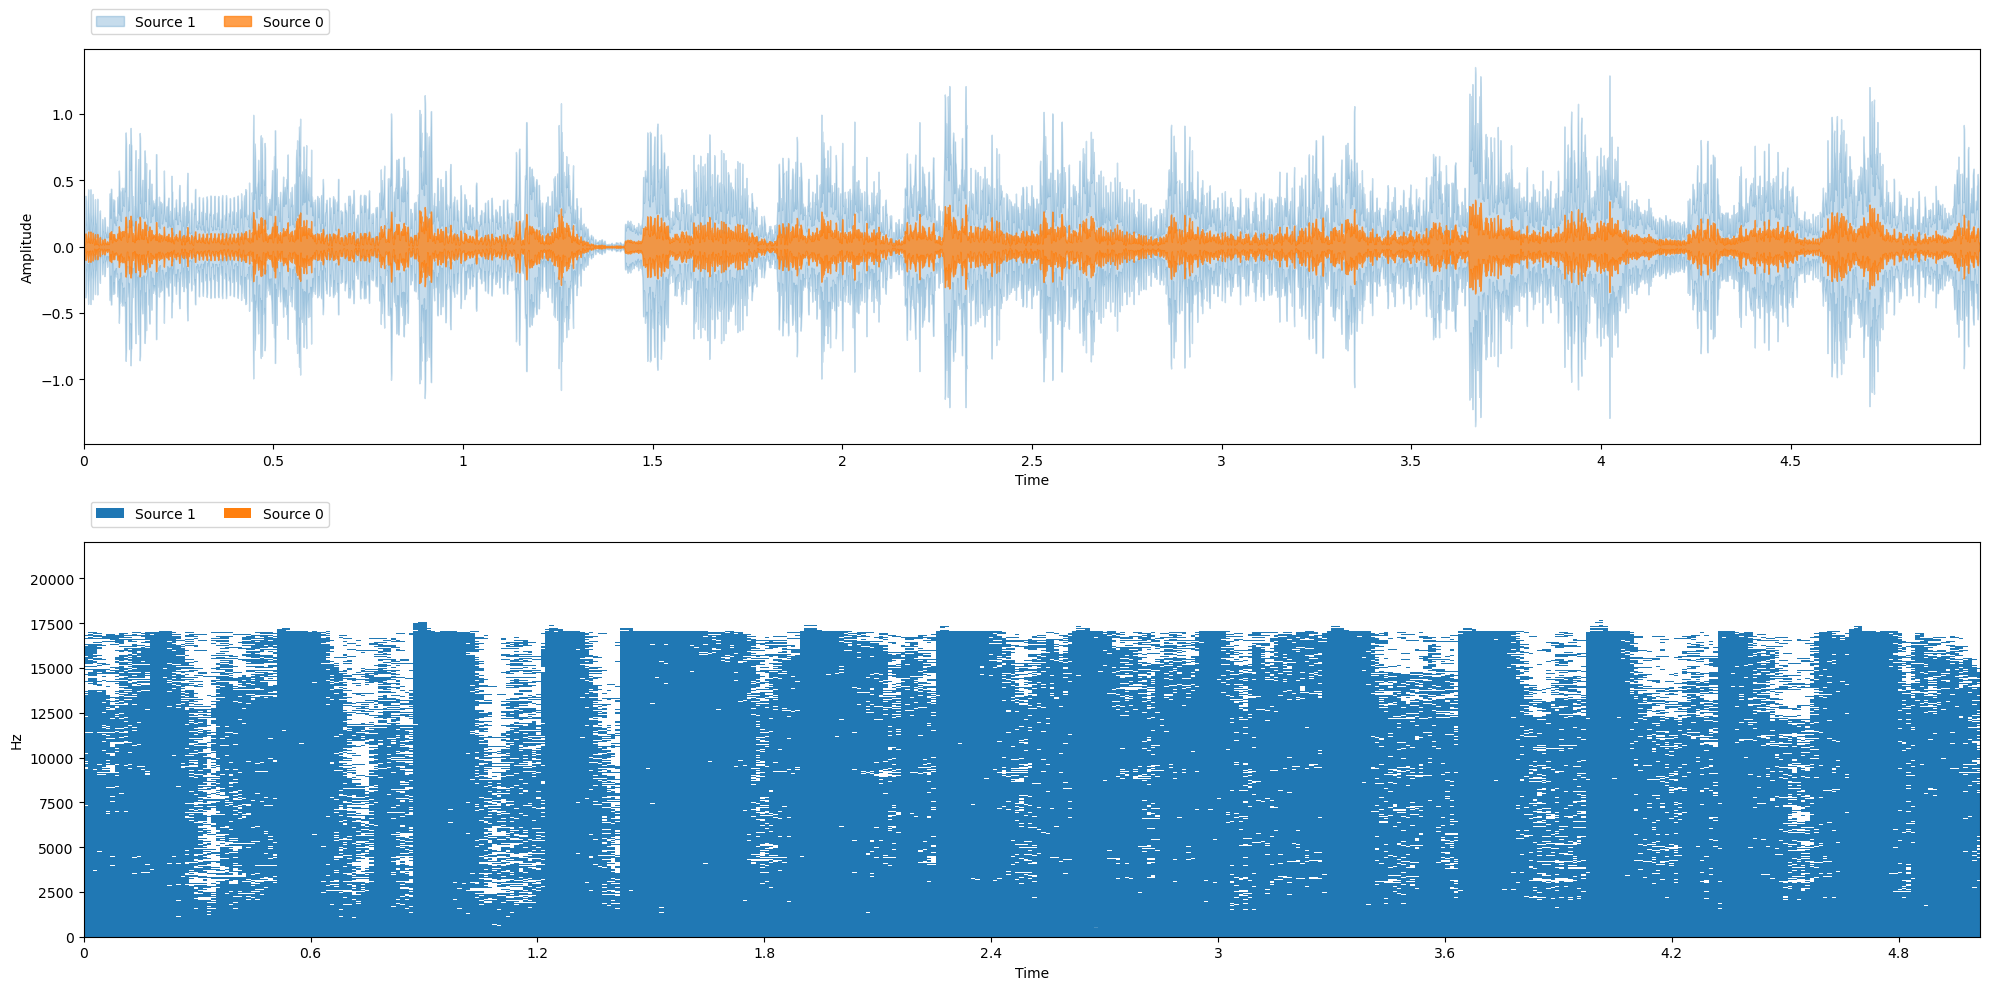


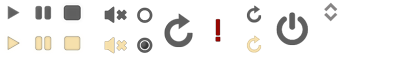
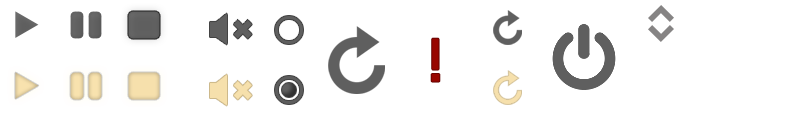
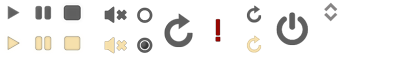

In [8]:
from utils import viz

test_folder = "~/audio_isolation/data/tutorial/test/"
test_data = data.mixer(stft_params, transform=None, 
    fg_path=test_folder, num_mixtures=MAX_MIXTURES, coherent_prob=1.0)
item = test_data[0]

separator.audio_signal = item['mix']
estimates = separator()
# Since our model only returns one source, let's tack on the
# residual (which should be accompaniment)
estimates.append(item['mix'] - estimates[0])

viz.show_sources(estimates)

In [15]:
import json

tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
])
#test_dataset = nussl.datasets.MUSDB18(subsets=['test'], transform=tfm)
test_dataset = data.mixer(stft_params, transform=tfm, 
    fg_path=test_folder, num_mixtures=MAX_MIXTURES, coherent_prob=1.0)

# Just do 5 items for speed. Change to 50 for actual experiment.
for i in range(5):
    item = test_dataset[i]
    separator.audio_signal = item['mix']
    estimates = separator()

    source_keys = list(item['sources'].keys())
    estimates = {
        'vocals': estimates[0],
        'bass+drums+other': item['mix'] - estimates[0]
    }

    sources = [item['sources'][k] for k in source_keys]
    estimates = [estimates[k] for k in source_keys]

    evaluator = nussl.evaluation.BSSEvalScale(
        sources, estimates, source_labels=source_keys
    )
    scores = evaluator.evaluate()
    output_folder = Path(output_folder).absolute()
    output_folder.mkdir(exist_ok=True)
    output_file = output_folder / sources[0].file_name.replace('wav', 'json') # Path(str(separator.audio_signal.file_name) + '.json')
    with open(output_file, 'w') as f:
        json.dump(scores, f, indent=4)

AttributeError: 'NoneType' object has no attribute 'replace'

In [16]:
import glob
import numpy as np

json_files = glob.glob(f"*.json")
df = nussl.evaluation.aggregate_score_files(
    json_files, aggregator=np.nanmedian)
nussl.evaluation.associate_metrics(separator.model, df, test_dataset)
report_card = nussl.evaluation.report_card(
    df, report_each_source=True)
print(report_card)

ValueError: No objects to concatenate

In [ ]:
separator.model.save('checkpoints/best.model.pth')

In [ ]:
model_checkpoint = torch.load('checkpoints/best.model.pth')

In [ ]:
model_checkpoint['metadata'].keys()

In [ ]:
model_checkpoint['metadata']['evaluation']